In [24]:
#Model : 1_MDTest7k

epochs = 10
path='bestmodel_1_MDTest7k.h5'
plot1 = 'accuracy_1_MDTest7k.jpg'
plot2 = 'loss_1_MDTest7k.jpg'
plot3 = 'f1_1_MDTest7k.jpg'
resultcsv = 'result_1_MDTest7k.csv'

In [6]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers

In [7]:
import keras as ks
import pandas as pd
import numpy as np
from PIL import Image
from keras.layers import Input
from keras.models import Model

In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
df1=pd.read_csv("train set AU.csv")
df2=pd.read_csv("validation set AU.csv")

In [23]:
columns=["AU1", "AU2", "AU4", "AU6", "AU12","AU15","AU20","AU25"]
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=datagen.flow_from_dataframe(dataframe=df1,directory="train set AU",x_col="ID",y_col=columns,batch_size=128,seed=42,shuffle=True,class_mode="other",target_size=(100,100))
valid_generator=test_datagen.flow_from_dataframe(dataframe=df2[0:60000],directory="validation set AU",x_col="ID",y_col=columns,batch_size=32,seed=42,shuffle=True,class_mode="other",target_size=(100,100))

Found 224729 validated image filenames.
Found 60000 validated image filenames.


In [14]:
from keras.callbacks import Callback
from keras.backend import clear_session
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten
from keras.applications import ResNet50



In [15]:
from keras.applications.resnet50 import ResNet50

In [16]:
#import sys
img = Input(shape=(100,100,3))
model = ResNet50(include_top=False, weights='imagenet', input_tensor=img, input_shape=(100,100,3), pooling='avg')
#food dataset kind
dense_layer_1 = Dense(128, activation = 'relu')(model.output)
output_layer = Dense(8, activation = 'sigmoid')(dense_layer_1)

model = Model(inputs = img, outputs = output_layer)
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])#check optimizer
model.compile(optimizers.adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy",f1_m])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [22]:
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint(path, monitor='val_f1_m', mode='max', save_best_only=True)
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,verbose=1,callbacks=[mc]
)

Epoch 1/10
   1/1755 [..............................] - ETA: 10:52:51 - loss: 0.2284 - accuracy: 0.9297 - f1_m: 0.3571

KeyboardInterrupt: 

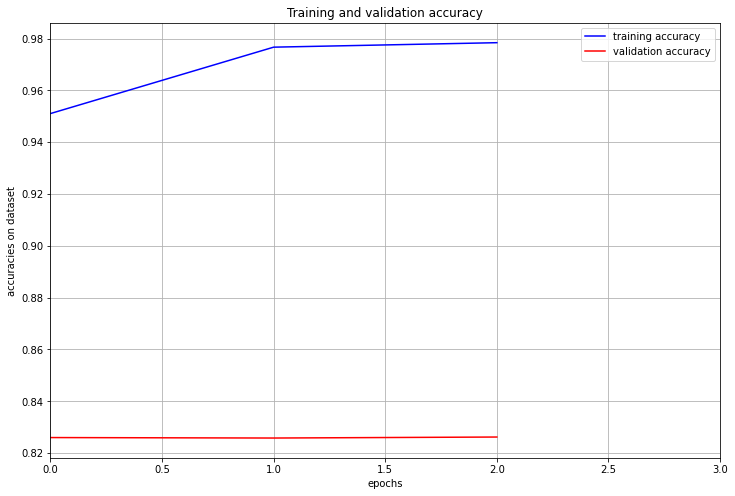

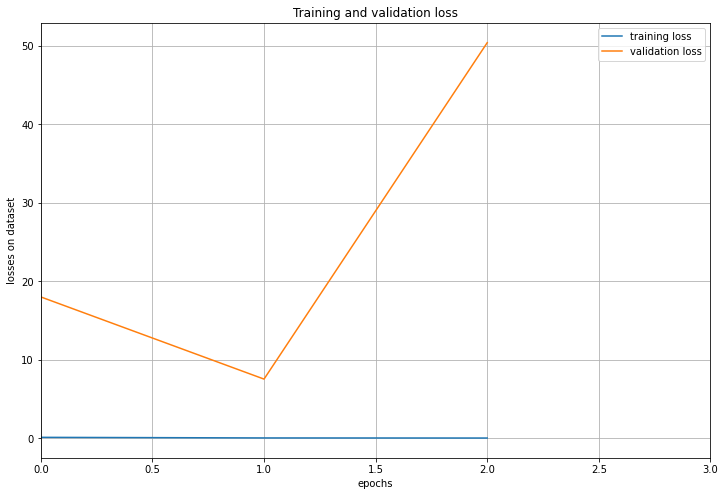

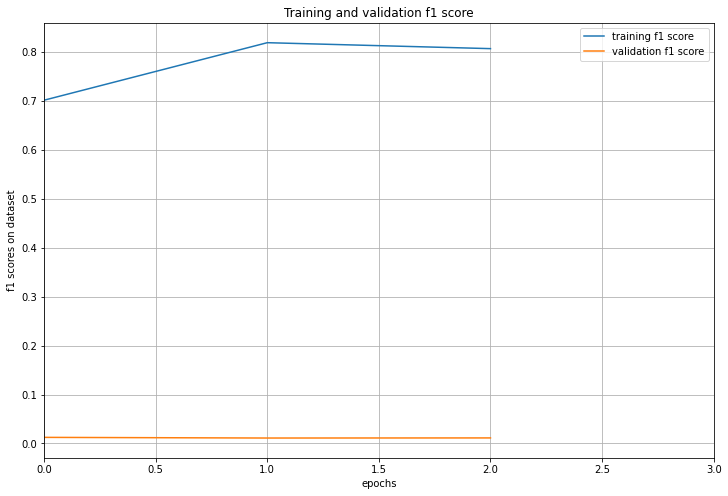

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plt.plot(range(epochs),history.history['accuracy'],label='training accuracy', color = "blue")
plt.plot(range(epochs),history.history['val_accuracy'],label='validation accuracy', color = "red")
plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('accuracies on dataset')
plt.grid(True)
plt.title("Training and validation accuracy")
plt.show()
fig.savefig(plot1)
plt.close(fig)
fig = plt.figure(figsize=(12,8))
plt.plot(range(epochs),history.history['loss'],label='training loss')
plt.plot(range(epochs),history.history['val_loss'],label='validation loss')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('losses on dataset')
plt.grid(True)
plt.title("Training and validation loss")
plt.show()
fig.savefig(plot2)
plt.close(fig)
fig = plt.figure(figsize=(12,8))
plt.plot(range(epochs),history.history['f1_m'],label='training f1 score')
plt.plot(range(epochs),history.history['val_f1_m'],label='validation f1 score')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('f1 scores on dataset')
plt.grid(True)
plt.title("Training and validation f1 score")
plt.show()
fig.savefig(plot3)
plt.close(fig)

In [15]:
from keras.models import load_model
model1 = load_model(path,custom_objects={'f1_m':f1_m})

In [16]:
#test=train
df3=df2[60000:]
y_test= df3.drop(['ID'], axis = 1)
y_test = y_test.to_numpy()
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(dataframe=df3,directory="validation set AU",x_col="ID",batch_size=1,seed=42,shuffle=False,class_mode=None,target_size=(100,100))
STEP_SIZE_TEST=test_generator.n

y_pred=model1.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
y_pred=(y_pred>0.5)
y_pred=y_pred.astype(int)

Found 7106 validated image filenames.
7106/7106 [==============================] - 407s 57ms/step


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [19]:
num=test_generator.n
print("Metrics for AU1\n")
y_test_AU1 = [0.0]*num
y_pred_AU1=[0.0]*num
for i in range(num):
    y_test_AU1[i]=y_test[i][0]
    y_pred_AU1[i]=y_pred[i][0]
print("\nTrue values\n")
print(y_test_AU1)
print("\nPredicted values\n")
print(y_pred_AU1)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU1, y_pred_AU1))
print(metrics.classification_report(y_test_AU1, y_pred_AU1))

Metrics for AU1


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [48]:
print("Metrics for AU2\n")
y_test_AU2 = [0.0]*num
y_pred_AU2=[0.0]*num
for i in range(num):
    y_test_AU2[i]=y_test[i][1]
    y_pred_AU2[i]=y_pred[i][1]
print("\nTrue values\n")
print(y_test_AU2)
print("\nPredicted values\n")
print(y_pred_AU2)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU2, y_pred_AU2))
print(metrics.classification_report(y_test_AU2, y_pred_AU2))

Metrics for AU2


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [49]:
print("Metrics for AU4\n")
y_test_AU4 = [0.0]*num
y_pred_AU4=[0.0]*num
for i in range(num):
    y_test_AU4[i]=y_test[i][2]
    y_pred_AU4[i]=y_pred[i][2]
print("\nTrue values\n")
print(y_test_AU4)
print("\nPredicted values\n")
print(y_pred_AU4)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU4, y_pred_AU4))
print(metrics.classification_report(y_test_AU4, y_pred_AU4))

Metrics for AU4


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [50]:
print("Metrics for AU6\n")
y_test_AU6 = [0.0]*num
y_pred_AU6=[0.0]*num
for i in range(num):
    y_test_AU6[i]=y_test[i][3]
    y_pred_AU6[i]=y_pred[i][3]
print("\nTrue values\n")
print(y_test_AU6)
print("\nPredicted values\n")
print(y_pred_AU6)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU6, y_pred_AU6))
print(metrics.classification_report(y_test_AU6, y_pred_AU6))

Metrics for AU6


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [51]:
print("Metrics for AU12\n")
y_test_AU12 = [0.0]*num
y_pred_AU12=[0.0]*num
for i in range(num):
    y_test_AU12[i]=y_test[i][4]
    y_pred_AU12[i]=y_pred[i][4]
print("\nTrue values\n")
print(y_test_AU12)
print("\nPredicted values\n")
print(y_pred_AU12)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU12, y_pred_AU12))
print(metrics.classification_report(y_test_AU12, y_pred_AU12))

Metrics for AU12


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [52]:
print("Metrics for AU15\n")
y_test_AU15 = [0.0]*num
y_pred_AU15=[0.0]*num
for i in range(num):
    y_test_AU15[i]=y_test[i][5]
    y_pred_AU15[i]=y_pred[i][5]
print("\nTrue values\n")
print(y_test_AU15)
print("\nPredicted values\n")
print(y_pred_AU15)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU15, y_pred_AU15))
print(metrics.classification_report(y_test_AU15, y_pred_AU15))

Metrics for AU15


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [53]:
print("Metrics for AU20\n")
y_test_AU20 = [0.0]*num
y_pred_AU20=[0.0]*num
for i in range(num):
    y_test_AU20[i]=y_test[i][6]
    y_pred_AU20[i]=y_pred[i][6]
print("\nTrue values\n")
print(y_test_AU20)
print("\nPredicted values\n")
print(y_pred_AU20)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU20, y_pred_AU20))
print(metrics.classification_report(y_test_AU20, y_pred_AU20))

Metrics for AU20


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [54]:
print("Metrics for AU25\n")
y_test_AU25 = [0.0]*num
y_pred_AU25=[0.0]*num
for i in range(num):
    y_test_AU25[i]=y_test[i][7]
    y_pred_AU25[i]=y_pred[i][7]
print("\nTrue values\n")
print(y_test_AU25)
print("\nPredicted values\n")
print(y_pred_AU25)
from sklearn import metrics
print("\nconfusion matrix\n")
print(metrics.confusion_matrix(y_test_AU25, y_pred_AU25))
print(metrics.classification_report(y_test_AU25, y_pred_AU25))

Metrics for AU25


True values

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [25]:
columns=["AU1", "AU2", "AU4", "AU6", "AU12","AU15","AU20","AU25"]
#columns should be the same order of y_col
results=pd.DataFrame(y_pred, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv(resultcsv,index=False)

NameError: name 'y_pred' is not defined